In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from plot_post import plot_post

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Modelos Multiparamétricos y Modelado jerárquico

En este capítulo veremos como crear y analizar modelos con más de un parámetro y estudiaremos como generar modelos jerárquicos, es decir modelos donde unos parámetros dependenden de otros.

## Modelos Multiparamétricos

Prácticamente todos los modelos de interés en estadística, son multiparamétricos, es decir modelos con más de un parámetro. Suele suceder que no todos los parámetros requeridos para construir un modelo son de interés, supongamos que quisieramos estimar el valor médio de una distribucion que asumimos Gaussiana, a menos que sepamos el valor _real_ de la desviación estandard, nuestro modelo deberá contener (al menos) dos parámentros a estimar: la media y la desviación estandard. Los parámetros que no son de inmediato interés pero son necesarios para construir nuestros modelos se llaman _nuissance parameters_. Recordemos que en estadística Bayesiana todos los parámetros tienen el mismo estatus, por lo que la diferencia entre _nuissance_ o no _nuissance_ no es fundamental bajo ningún concepto, si no que depende completamente de nuestras preguntas.

En principio podría parecer que incorporar parámetros que no nos interesan en nuestros modelos es un ejercicio de futilidad. Sin embargo, es todo lo contrario, al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propaguen de forma adecuada a los resultados.

En terminos generales un modelo con dos parámetros será algo como:

$$p(\theta_1, \theta_2|y) \propto p(y|\theta_1, \theta_2) p(\theta_1, \theta_2)$$

lo que facilment se puede generalizar a un modelo multiparamétrico. La principal diferencia con lo que ya habiamos visto es que ahora el _a posteriori_ será bidimensional (asumiendo que $\theta_1$, $\theta_2$, son escalares aunque bien podrían ser vectores).

Supongamos por un momento que $\theta_2$ no nos interesa realmente ¿Como hacemos entonces para expresar el _a posteriori_ solo en terminos de $\theta_1$? Lo que debemos hacer es obtener la distribución marginal del _a posteriori_ respecto del parámetro de interés. Matemáticamente esto es:

$$p(\theta_1|y) = \int p(\theta_1, \theta_2|y) d\theta_2$$

Es decir integramos el _a posteriori_ sobre todos los valores posibles de los parámetros que no nos interesan inmediatamente. En general, esta integral no se calcula de forma explícita, ya que el _a posteriori_ lo obtenemos por simulación. En esto casos, como veremos a continuación simplemente se muestrea el _a posteriori_ completo y luego tan solo se miran los resultados de los parámetros que nos interesan.

En 1882 Simon Newcomb realizó un experimento a fin de determinar la velocidad de la luz (en realidad realizó varios a lo largo de varios años). Newcomb midió el tiempo que le tomaba a la luz recorrer 7.4437 kilómetros. A continuación se muestra sus resultados, 66 mediciones expresadas en $1\times10^{-2}$ segundos.

In [2]:
datos = np.array([24828, 24826, 24833, 24824, 24834, 24756, 24827, 24816, 24840, 24798, 24829, 24822, 24824, 24821, 24825, 24830, 24823, 24829, 24831, 24819, 24824, 24820, 24836, 24832, 24836, 24828, 24825, 24821, 24828, 24829, 24837, 24825, 24828, 24826, 24830, 24832, 24836, 24826, 24830, 24822, 24836, 24823, 24827, 24827, 24828, 24827, 24831, 24827, 24826, 24833, 24826, 24832, 24832, 24824, 24839, 24828, 24824, 24825, 24832, 24825, 24829, 24827, 24828, 24829, 24816, 24823])

Si graficamos estas medidas veremos que la distribución parece gaussiana excepto por dos medidas inusualmente bajas.

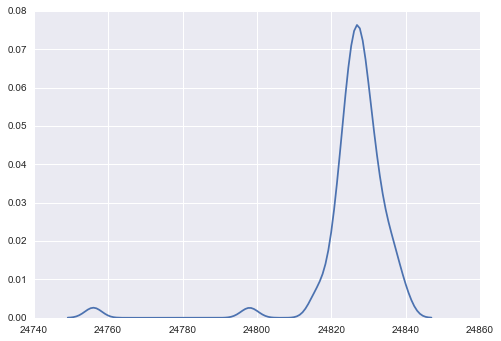

In [3]:
sns.kdeplot(datos);

Por simplicidad vamos a suponer que los datos siguen una distribución gaussiana, después de todo es lo que en general se esperaría al medir una misma cosa varias veces. Una distribución gaussiana queda definida por dós parámetros, la media y la desviación estandard. Por lo tanto necesitamos fijar dos _a prioris_ uno para cada parámentro. Un modelo probabílistico razonable sería el siguiente.

$$\mu \sim \mathcal{U}(l, h)$$
$$\sigma \sim \mathcal{HN}(\sigma_h)$$
$$y \sim \mathcal{N}(\mu, \sigma)$$

Es decir, $\mu$ proviene de una distribución uniforme entre los límites $l$ y $h$, $\sigma$ es proviene de una media-normal (_half-normal_) con desviación estandard $s_h$, esta distribución es como una Gaussiana, pero solo definida en el rango $[0, \infty]$. Y los datos, como dijimos anteriormente, proviene de una distribución normal, especificada por $\mu$ y $\sigma$.

Graficamente:

<img src="imagenes/velocidad_luz_g.png" width=400>

Si desconocemos por completo cuales podrían ser los valores de $\mu$ y de $\sigma$, podemos fijar valores para los _a prioris_ que reflejen nuestra ignorancia. Para la distribución uniforme una opción podria ser fijar $(l=0, h=1\times10^9)$, es decir asumimos que el tiempo que le demora a la luz recorrer los 7442 métros del experimento va entre 0 y 1 segundo. Alternativamente podríamos haber elegido $(l=24000, h=25000)$, que es un rango bastante más amplio que el de los datos. Ante la duda calculen ambos modelos y evaluaen el efecto que tiene uno y otro _a priori_. Siguiendo la misma linea para la media-normal eligiremos $(s_h=10)$

In [4]:
with pm.Model() as modelo_g:
    # los a prioris
    mu = pm.Uniform('mu', 24000, 25000) 
    sigma = pm.HalfNormal('sigma', sd=10)
    # el likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=datos)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_g = pm.sample(10000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.3 sec

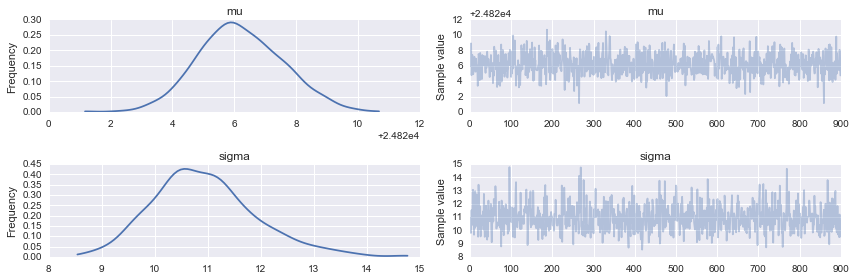

In [5]:
burnin = 1000
thinin = 10
cadena_g = trace_g[burnin::thinin]
pm.traceplot(cadena_g, vars=modelo_g.deterministics);

In [6]:
pm.summary(cadena_g, vars=[mu, sigma])


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  24826.206        1.385            0.045            [24823.895, 24829.234]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  24823.533      24825.250      24826.086      24827.111      24828.983


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.937           0.977            0.034            [9.258, 13.090]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.268          10.306         10.858         11.494         13.139



Un problema con este modelo es que asume una distribución normal pero tenemos dos puntos que caen muy alejados de los valores medios. Una opción es eliminarlos bajo el criterio de ser datos aberrantes, usando por ejemplo el criterio del rango intercuartil. Otra opción es dejarlos pero utilizar un modelo mas robusto (menos afectado por los datos aberrantes). Para ello asumir que los datos siguen una distribución t de student, en vez de una normal. Esta distribución es similar a la Gaussiana solo que tiene colas más gordas, es decir es una distribución que considera a puntos alejados de la media con mayor probabilidad que lo que lo haría una Gaussiana. Además de estar definida por la media y la desviación standard, esta distribución tiene un parámetro $\nu$, cuando este parámetro es 1 tenemos la distribución de Cauchy (o Lorentz) y en el limite de de $\nu$ tendiendo a infinito tenemos la distribución gaussiana. 

$$\mu \sim \mathcal{U}(l, h)$$
$$\sigma \sim \mathcal{HN}(\sigma_h)$$
$$\nu \sim \mathcal{U}(l, h)$$
$$y \sim \mathcal{t}(\mu, \sigma, \nu)$$

Graficamente:

<img src="imagenes/velocidad_luz_t.png" width=500>

In [7]:
with pm.Model() as modelo_t:
    # los a prioris
    mu = pm.Uniform('mu', 24000, 25000)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Uniform('nu', 1, 100)
    # del likelihood
    y = pm.T('y', mu=mu, sd=sigma, nu=nu, observed=datos)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_t = pm.sample(10000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.5 sec

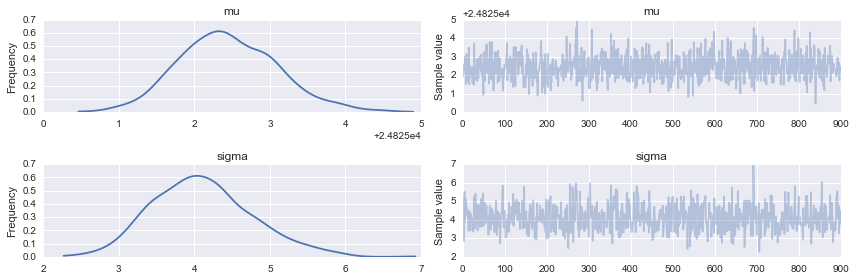

In [8]:
burnin = 1000
thinin = 10
cadena_t = trace_t[burnin::thinin]
pm.traceplot(cadena_t, vars=[mu, sigma]);

In [9]:
pm.summary(cadena_t, vars=[mu, sigma, nu])


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  24827.454        0.655            0.025            [24826.151, 24828.740]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  24826.273      24826.999      24827.403      24827.894      24828.868


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.108            0.659            0.025            [2.963, 5.508]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.971          3.642          4.072          4.496          5.537


nu:

  Mean             SD               MC Error         95% HPD interval
  -------------------

En este caso, vemos que la estimación de $\mu$ es muy similar entre los dos modelos, aunque la estimación de $\sigma$, pasó de ser de ~10 a ~4. Esto es consecuencia de que la distribución t asigna menos peso a los valores alejados de la media que la distribución Gaussiana. 
Según mediciones más modernas $\mu$ debería andar alrededor de ~22315, bastante alejado de las medidas realizadas por Newcomb en este experimento (otros experimentos realizados por el dieron valores más cercanos a las medidas actuales).

## Modelos Jerárquicos.

El siguiente ejemplo está tomado del capítulo 9 del libro "Doing Bayesian Data Analysis de John K. Kruschke". Supongamos que en vez de una moneda tenemos 3, supongamos además que sabemos que las tres monedas fueron hechas con la misma matriz (en la misma fábrica). Para estimar el valor de $\theta$ tenemos dos opciones:

1) estimar un valor de $\theta$ para cada moneda por separado.

2) juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

La ventaja de la opción 1 es que las monedas podrían diferir entre si por lo que calcular 3 valores de  $\theta$ podría ser muy informativo. La desventaja de este modelo es que hace caso omiso a la información que indica que las 3 monedas tienen un origen común, por lo que es probable que compartan características.

La ventaja de la opción 2 es que la cantidad de datos por parámetro aumentó, lo que reduce la incerteza. El problema es que pasamos a asumir que las 3 monedas son en realidad una, lo no sería problemático si las tres monedas fueran muy similares entre si, pero esto podría no ser una buena aproximación.

Una tercera opción, usada frecuentemente en estadística, es hacer algo a mitad de camino entre 1 y 2. Esto se consigue construyendo un modelo jerárquico,  es decir un modelo donde algunos parámetros dependen de los valores de otros parámetros. 

En estadística Bayesiana construir modelos jerárquicos es sencillo. A continuación veremos que un modelo jerárquico para las 3 monedas es muy similar al usado para el caso de 1 sola moneda solo que ahora colocamos un _a priori_ sobre el _a priori_!

Recordemos, el modelo del capítulo anterior era:

$$\theta \sim \operatorname{Beta}(\alpha, \beta)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

En un modelo jerárquico los argumentos de la distribución Beta ($\alpha$ y $\beta$) no son constantes si no que son valores que proviene de alguna otra distribución. En nuestro tendremos que:

$$ \mu \sim \operatorname{Beta}(\alpha, \beta)$$
$$ \kappa = \operatorname{Gamma}(s, r)$$

$$\theta \sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

Graficamente, tenemos:

<img src="imagenes/modelo_3_monedas_jerarquico.png" width=500>

En los modelos jerárquicos a $\mu$ y a $\kappa$ se llama _hiper a prioris_ o _hiperparámetros_ ya que son ellas quienes determinan el valor del _a priori_. La diferencia entre el modelo del capítulo anterior y el del presente es que ahora los valores que puede tomar $\theta$ dependen no ya de una distribución fija($\alpha=1$ y $\beta=1$) si no de una distribución que depende de los valores de $\mu$ y $\kappa$, y que estimaremos a partir de los datos. Es decir es posible estimar el _a priori_ a partir de los datos, pero solo por que hemos introducido _hiper a prioris_. 

Recordarán que la distribucion Beta se podía parametrizar en terminos de $\alpha$ y $\beta$, pero también de $\mu$  y $\kappa$, donde $\mu$ es la media y $\kappa$ es la concentración (la inversa de la dispersión). Tenemos entonces que $\mu$ reflejará el valor promedio de 3 valores de $\theta$ y que si la proporción de caras en las tres monedas es similar entre si $\kappa$ tomara un valor más alto, mientras que si las monedas son diferentes entre si $\kappa$ tomará un valor más bajo. 

### ¿Por qué la elección de los hiper _a prioris_? 

Bueno dado que $\mu$ es la media del vector $\theta$ (y que $\theta$ solo puede tomar valores entre 0 y 1), $\mu$ queda restringida a valores entre 0 y 1 (al igual que una distribución beta), siguiendo el mismo razonamiento $\kappa$ va entre $[0, \infty]$ al igual que la distribución gamma. Otras distribuciones igualmente razonables podrían haber sido:

* $ \mu \sim \mathcal{U}(0, 1)$
* $ \kappa \sim \operatorname{HalfNormal}(\sigma=100)$


Primero que nada generemos algunos datos sintéticos y los pondremos de una forma que sea más simple pasarselos al modelo, esto quedará un poco más claro al la especificación del modelo.

Vamos a suponer que con cada una de las 3 monedas hicimos 10 experimentos de bernoulli (las arrojamos al aire) y obtuvimos como resultado, para cada caso, 5 caras.

In [10]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # Número de caras en los Ni experimentos.

# vector conteniendo los indices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos = datos + [1] * z[i] + [0] * (experimentos-z[i])

Como no sabemos demasido sobre $\mu$ y $\kappa$, vamos a elegir $ \mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$, lo que equivale a una distribución centrada en 0.5, pero que casi asigna la misma probabilidad a todos los valores entre 0 y 1. Y $ \kappa = \operatorname{Gamma}(s=1, r=0.1)$, lo que equivale a una curva centrada en 10 y con una desviación estandard de 10.

La especificación del modelo es igual a lo que hemos venido haciendo la única diferencia es que en la linea 7 podemos observar que hay una argumento llamando _shape_. Esto nos permite especificar las dimensiones de (en este caso) _theta_. PyMC3 permite escribir modelos _vectorizados_ ahorrandonos el tener que escribir _for loops_. Esa es la razón por la cual en la celda superior creamos un vector _monedas_ que usamos en la linea 9 (de la especificación del modelo) para indexar _theta_.

In [11]:
# Especificamos el modelo en PyMC3
with pm.Model() as modelo:
    # definimos los hyperparámetros
    mu = pm.Beta('mu', 2, 2)
    kappa = pm.Gamma('kappa', 1, 0.1)
    # definimos el a priori
    theta = pm.Beta('theta', mu * kappa, (1 - mu) * kappa, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=theta[monedas], observed=datos)

Ahora muestreamos el _a posteriori_ y hacemos todas las evaluaciones necesarias para determinar si hubo convergencia, para determinar cuanto _burnin_ y _thining_ son necesarios y para ver si los resultados tienen sentido!

In [12]:
with modelo:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 8.5 sec

In [13]:
burnin = 5000
thinin = 10
cadena = trace[burnin::thinin]

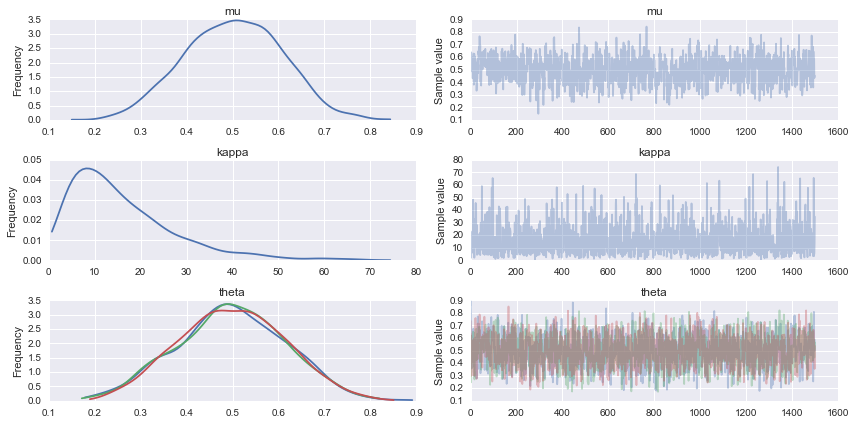

In [14]:
pm.traceplot(cadena, vars=[mu, kappa, theta]);

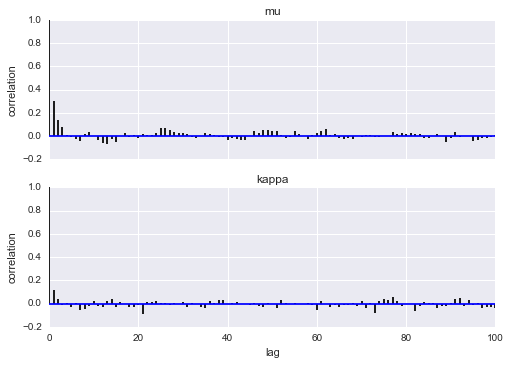

In [15]:
pm.autocorrplot(cadena, vars=[mu, kappa]);

In [16]:
pm.summary(cadena)


mu_logodds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.008            0.440            0.016            [-0.843, 0.836]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.854         -0.291         0.015          0.305          0.828


kappa_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.498            0.775            0.023            [0.836, 3.881]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.753          1.997          2.549          3.054          3.827


theta_logodds:

  Mean             SD               MC Error         95% HPD interval
  -------

Podemos observar que el valor de $\kappa$ del _a posteriori_ es mayor que del _a priori_. Esto es razonable ya que los experimentos con las 3 han resultado idénticos indicando que la matriz tiene un efecto importante sobre el resultado de $\theta$ para cada moneda.

¿Qué distribución hubieamos obtenido para $\kappa$ si las monedan hubieran mostrado distintos resultados?
Probemos que hubiera pasado si:

z = [1, 5, 9]

### Mirando el _a posteriori_ desde varios lados

El _a posteriori_ contiene toda la información que resulta de un análisis Bayesiano. Por lo que puede ser muy informativo analizarlo desde varios lados. Además de los gráficos que provee PyMC3, podemos analizar el _a posteriori_ usando nuestras propias gráficas, por ejemplo podemos estar interesados en observar como se correlacionan distintos parámetros.

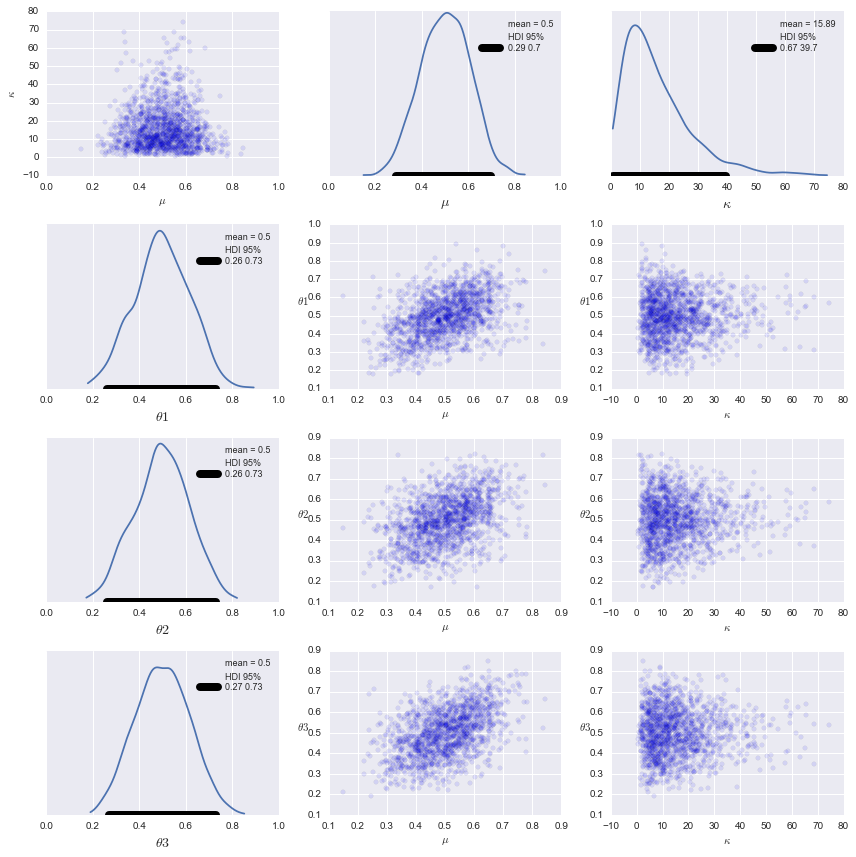

In [17]:
# Create arrays with the posterior sample
theta1_pos = cadena['theta'][:,0]
theta2_pos = cadena['theta'][:,1]
theta3_pos = cadena['theta'][:,2]
mu_pos = cadena['mu']
kappa_pos = cadena['kappa']

fig = plt.figure(figsize=(12,12))

# Scatter plot hyper-parameters
plt.subplot(4, 3, 1)
plt.scatter(mu_pos, kappa_pos, marker='o', alpha=0.1)
plt.xlim(0,1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\kappa$')

plt.subplot(4, 3, 2)
plot_post(mu_pos, xlab=r'$\mu$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlim(0,1)

plt.subplot(4, 3, 3)
plot_post(kappa_pos, xlab=r'$\kappa$', show_mode=False, labelsize=9, framealpha=0.5)

count = 4
for i, j in (theta1_pos, 'theta1'), (theta2_pos, 'theta2'), (theta3_pos, 'theta3'):
    plt.subplot(4, 3, count)
    plot_post(i, xlab='$\{}$'.format(j), show_mode=False, labelsize=9, framealpha=0.5)
    plt.xlim(0,1)
    count += 1
    for k, l in (mu_pos, 'mu'), (kappa_pos, 'kappa'):
        plt.subplot(4, 3, count)
        plt.scatter(k, i, marker='o', alpha=0.1)
        plt.xlabel('$\{}$'.format(l))
        plt.ylabel('$\{}$'.format(j), rotation=0)
        count += 1

plt.tight_layout();

### Contracción

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

¿Cuáles son los valores de $\theta$ obtenidos en cada caso? Es lo mismo el valor estimado de $\theta$ para una moneda cuando cae 1 de 10 veces caras (y las otras dos también), que cuando una moneda cae 1 de 10 veces caras y las otras dos caen 9 de 10 veces cara?

Como podrán ver si hacen el ejercicio, el valor estimado $\theta$ no es el mismo! ¿Por qué sucede esto?

Porque el modelo especifica que las monedas NO son independientes. El modelo asume que las 3 monedas provienen de una misma matriz, por lo tanto la estimación de $\theta$ para una moneda es afectada por las otras y al mismo tiempo afecta a las otras. Este fenómeno se llama contracción, la razón del nombre es que las estimaciones individuales tienden a contraerse alrededor del valor promedio de las 3 estimaciones (en nuestro modelo $\mu$) esto se hace mas evidente para los valores _aberrantes_. Si todas las monedas menos una indican un valor de $\theta$ más o menos similar la que posee el valor distinto tendrá un $\theta$ mucho más cercano al valor de las demás que si la hubieramos estimado de forma individual.

Esto quizá pueda parecerles problemático, pero no es más que un reflejo de lo que asumimos al crear el modelo. La matriz con la que fueron hechas las monedas influencia el sesgo de las mismas. Entonces, la estimación de cada elemento del vector $\theta$ debe influenciar y ser influenciado por las estimaciones de los demás elementos de $\theta$. Esto es una forma de regularización que los métodos frecuentistas deben introducir _ad-hoc_, pero que sin embargo ya viene incluido en un análisis Bayesiano.

Entonces el modelo jerárquico Bayesiano que hemos construido nos dice no solo los valores de $\theta$, si no lo valores de $\mu$ (el sesgo promedio) introducido por la matriz y los valores de $\kappa$, cuan fuerte es el efecto de la matriz sobre los sesgos individuales de $\theta$

-

In [18]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.0.0
PyMC3 3.0
NumPy 1.10.1
SciPy 0.16.1
Matplotlib 1.5.0
Seaborn 0.6.0

